In [1]:
import pandas as pd
import numpy as np
import scipy.special
import math
import gc
import copy
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import os
import seaborn as sns

#Import Data
from ReadAndCleanData import train_csv, test_csv, submission_csv, structures_csv


Loading Data...
Data Captured


We build a pipeline for adding features to our model:

In [2]:
#Import Features from  FeatureFunctions.py
import FeatureFunctions as FF

## Import pipeline to construct dataset with new features from original data set
import BuildFeatureDataFrame as B

In [3]:
## Takes Dataframe with all Features and Selects Features of Interest
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    labels.append('d_1_0')
    labels.append('0_local_valence_1.8')
    labels.append('1_local_valence_1.8')
    labels.append('local_weight_1')
    labels.append('local_weight_2')
    labels.append('local_weight_3')
    labels.append('local_weight_4')
    labels.append('local_weight_5')
    labels.append('num_two_edge_paths_1')
    labels.append('num_two_edge_paths_2')
    labels.append('num_two_edge_paths_3')
    labels.append('num_two_edge_paths_4')
    return df[labels]

Build a GBDT model to predict scalar coupling values

In [4]:
# Set LGB parameters
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 450,
    'min_child_samples': 79,
    'max_depth': 10,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [5]:
# Builds train and target data for one coupling type
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = B.build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)

    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)

    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
        y_data = df['scalar_coupling_constant'].values.astype('float32')
    else:
        X_data = df.values.astype('float32')
        y_data = None

    return X_data, y_data, df

In [6]:
## Trains a boosted decision tree model and predicts coupling values for one type
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5,
                                            random_state=128):
    print(f'*** Training Model for {coupling_type} ***')

    X_data, y_data, df = build_x_y_data(train_csv, coupling_type, n_atoms)
    X_test, _, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0

    if n_folds > n_splits:
        n_splits = n_folds

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        X_train, X_val = X_data[train_index], X_data[val_index]
        y_train, y_val = y_data[train_index], y_data[val_index]

        model = LGBMRegressor(**LGB_PARAMS, n_estimators=1000, n_jobs=-1)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                  verbose=1000, early_stopping_rounds=200)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        cols = list(df.columns)
        cols.remove('scalar_coupling_constant')
        df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
        sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False))
        plt.show()

        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds

    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [7]:
## Set n_atom parameters for each coupling type
model_params = {
    '1JHN': 7,
    '1JHC': 10,
    '2JHH': 9,
    '2JHN': 9,
    '2JHC': 9,
    '3JHH': 9,
    '3JHC': 10,
    '3JHN': 10
}
N_FOLDS = 2
submission = submission_csv.copy()


*** Training Model for 1JHN ***
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.711564	valid_1's l1: 1.09279
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.711564	valid_1's l1: 1.09279
1JHN Fold 0, logMAE: 0.0887363596942381


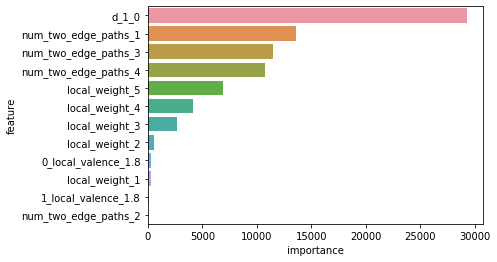

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[701]	valid_0's l1: 0.782899	valid_1's l1: 1.08207
1JHN Fold 1, logMAE: 0.07887279210209454


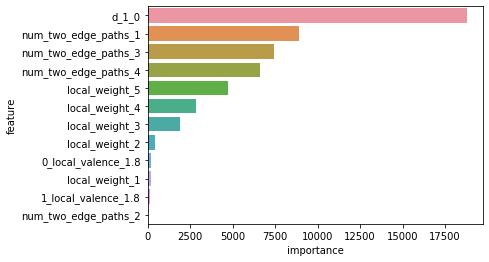

*** Training Model for 1JHC ***
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 2.01717	valid_1's l1: 2.27591
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.01717	valid_1's l1: 2.27591
1JHC Fold 0, logMAE: 0.822378526929596


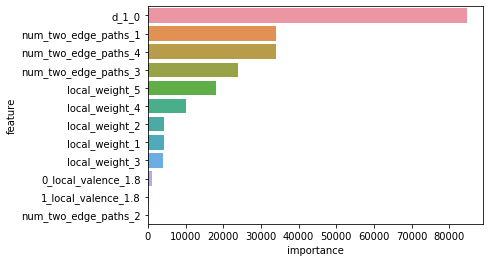

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 2.02212	valid_1's l1: 2.2664
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 2.02212	valid_1's l1: 2.2664
1JHC Fold 1, logMAE: 0.8181921680407102


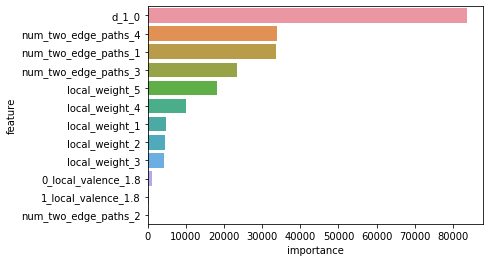

*** Training Model for 2JHH ***
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.456697	valid_1's l1: 0.569795
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.456697	valid_1's l1: 0.569795
2JHH Fold 0, logMAE: -0.5624781905113007


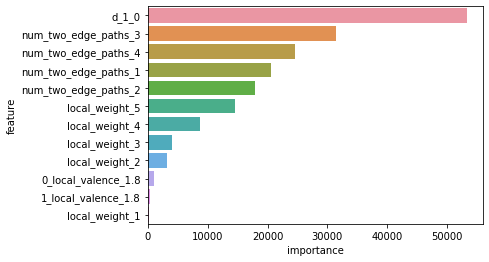

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[693]	valid_0's l1: 0.479228	valid_1's l1: 0.564351
2JHH Fold 1, logMAE: -0.5720796149341096


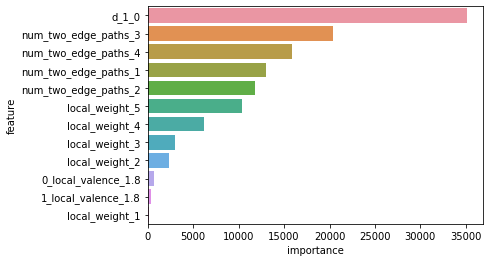

*** Training Model for 2JHN ***
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.332309	valid_1's l1: 0.486429
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.332309	valid_1's l1: 0.486429
2JHN Fold 0, logMAE: -0.7206645109517515


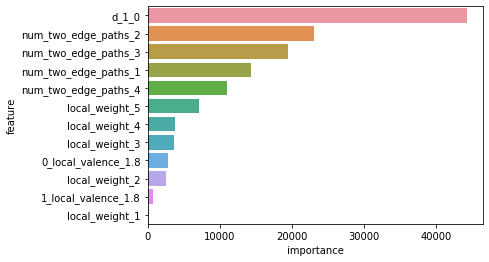

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.331162	valid_1's l1: 0.487716
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.331162	valid_1's l1: 0.487716
2JHN Fold 1, logMAE: -0.7180227890206801


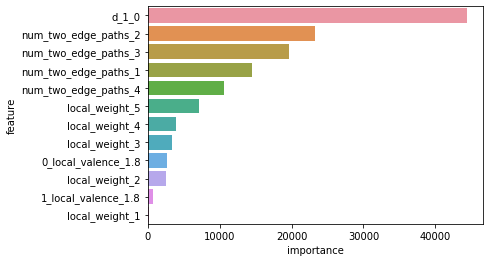

*** Training Model for 2JHC ***
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.780274	valid_1's l1: 0.912563
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.780274	valid_1's l1: 0.912563
2JHC Fold 0, logMAE: -0.09149810674568828


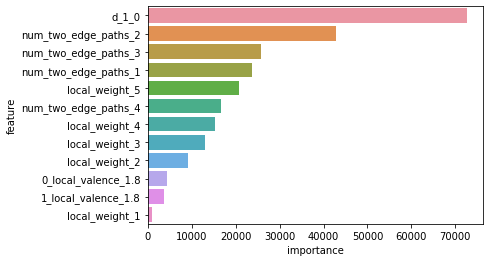

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.783444	valid_1's l1: 0.912089
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.783444	valid_1's l1: 0.912089
2JHC Fold 1, logMAE: -0.09201787280969681


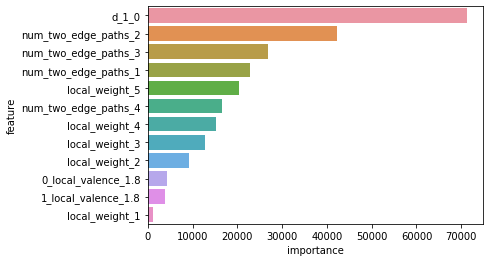

*** Training Model for 3JHH ***
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.492483	valid_1's l1: 0.584567
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.492483	valid_1's l1: 0.584567
3JHH Fold 0, logMAE: -0.5368833388389694


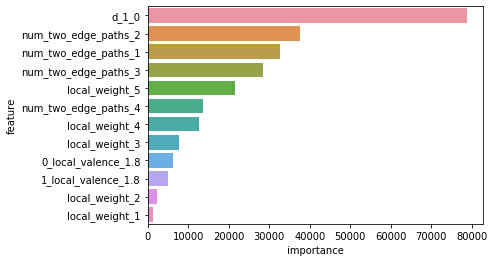

Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.491109	valid_1's l1: 0.587259
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.491109	valid_1's l1: 0.587259
3JHH Fold 1, logMAE: -0.5322884851346129


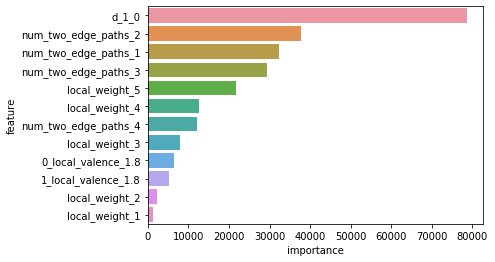

*** Training Model for 3JHC ***
Training until validation scores don't improve for 200 rounds.
[1000]	valid_0's l1: 0.814422	valid_1's l1: 0.900612
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.814422	valid_1's l1: 0.900612


In [ ]:
cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

#Check output CV scores
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})
np.mean(list(cv_scores.values()))

#Output Prediction Results
submission.to_csv('Data/submission.csv')